# Zebra Page Separation A/B Test Analysis Report 4: 
# Usage of page tools
__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__

July 2023

## TICKETS:
Instumentation planning : 
- Spec: [T333222](https://phabricator.wikimedia.org/T333222)

Instrumentation deployment :  
- Launch AB test: [T335972](https://phabricator.wikimedia.org/T335972)
- Fix bug: [T336969](https://phabricator.wikimedia.org/T336969) [T337955](https://phabricator.wikimedia.org/T337955)

Data tickets:
- Data QA: [T336299](https://phabricator.wikimedia.org/T336299)
- __Analysis: [T335379](https://phabricator.wikimedia.org/T335379)__

# Curiorsity Question2:  Does it impact the usage of Page tools? (Number of pins or unpins for the page tools)


In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [2]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [34]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Import data

In [9]:
df_pageviews <- read.csv("Data/pageviews_20230710.csv")

In [82]:
query_pagetool <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') and year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE  t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_anon
AND NOT is_bot
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks from ab test group
SELECT t3.event.token AS session_id, 
wiki, event.isanon,  t4.test_group, event.name, t3.event.editCountBucket, t3.event.pageToken,  count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND event.name IN (
-- To pin the page tool to the right sidebar
'pinnable-header.vector-page-tools.pin' ,
-- To unpin the page tool
 'pinnable-header.vector-page-tools.unpin'
)
AND event.action='click' AND event.skin='vector-2022'
-- exclude anonymous users, some sessions swtich between loggin mode and loggout mode.
AND NOT event.isanon
GROUP BY t3.event.token, t3.wiki, event.isanon, t4.test_group, event.name, t3.event.editCountBucket, t3.event.pageToken
"

In [83]:
df_pagetool <- wmfdata::query_hive(query_pagetool)

Don't forget to authenticate with Kerberos using kinit



In [17]:
#df_pagetool <-  read.csv('Data/pagetool_20230622.csv')

In [84]:
summary(df_pagetool)

  session_id            wiki              isanon           test_group       
 Length:6615        Length:6615        Length:6615        Length:6615       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     name           editcountbucket     pagetoken             clicks     
 Length:6615        Length:6615        Length:6615        Min.   :1.000  
 Class :character   Class :character   Class :character   1st Qu.:1.000  
 Mode  :character   Mode  :character   Mode  :character   Median :1.000  
                                                          Mean   :1.033  
                                                          3rd Qu.:1.000  
                 

In [15]:
df_pagetool_W <- df_pagetool %>%
  mutate(action=case_when(
           name=='pinnable-header.vector-page-tools.unpin' ~ 'unpins',
           name=='pinnable-header.vector-page-tools.pin' ~ 'pins'
           )
         ) %>%
  select(session_id,wiki,isanon,test_group,action, editcountbucket,pagetoken,clicks ) %>%
  spread(key=action, value=clicks, fill=0)

### Note
Pin and unpin action depend on the previous setting. The page tool is pinned by default. Expected to have more unpin than pin as more users initially landed with the pinned page tool. 

In [17]:
df_pagetool_pv <- merge( df_pageviews,df_pagetool_W ,by.x=c("session_id","page_token","wiki","test_group","editcountbucket"), by.y=c("session_id","pagetoken","wiki","test_group","editcountbucket"),all.x=TRUE )

In [19]:
dim(df_pagetool_pv)

[1] 19921367        9

### Note
Noticed that some sessions which have pin/unpin events are not recorded with session initialtion. After debugging, confirmed the mismach of pins and unpins in df_pagetool_pv  and df_pagetool is due to left join and outer join. Some sessions with pin/unpin events don't have session initilization satisfied timestamp requirement.

For example, session '007c4695eedcb9b6fff6' is missing in df_pageviews as it's not satisfied ` t4.session_dt(ab test enrollment) <= t3.meta.dt (session init)` . But its click dt > dt of ab test enrollment.

Decision: exclude pin/unpin events which initial a session before ab test enrollment though pinned/unpinned after ab test enrollment, considering we are not sure which version the user saw when they pinned/unpinned the page tool.

In [20]:
df_pt_pv_per_session  <- df_pagetool_pv %>% 
   group_by(session_id, wiki,test_group) %>%
   summarize(n_pvs=sum(pvs), n_pages=n_distinct(page_token), n_pins=sum(pins, na.rm=T), n_unpins=sum(unpins,na.rm=T), .groups='drop')

In [22]:
summary(df_pt_pv_per_session)

  session_id            wiki            test_group            n_pvs      
 Length:1106811     Length:1106811     Length:1106811     Min.   :    1  
 Class :character   Class :character   Class :character   1st Qu.:    1  
 Mode  :character   Mode  :character   Mode  :character   Median :    4  
                                                          Mean   :   18  
                                                          3rd Qu.:   11  
                                                          Max.   :31002  
    n_pages          n_pins           n_unpins        
 Min.   :    1   Min.   :0.00000   Min.   : 0.000000  
 1st Qu.:    1   1st Qu.:0.00000   1st Qu.: 0.000000  
 Median :    4   Median :0.00000   Median : 0.000000  
 Mean   :   18   Mean   :0.00087   Mean   : 0.004782  
 3rd Qu.:   11   3rd Qu.:0.00000   3rd Qu.: 0.000000  
 Max.   :31002   Max.   :8.00000   Max.   :10.000000  

In [23]:
df_pt_pv_per_session <- df_pt_pv_per_session %>%
  mutate(is_pinned_or_unpinned=(n_pins>0)|(n_unpins>0)
    )
    

In [24]:
df_pt_pv_per_session <- df_pt_pv_per_session %>%
  mutate(
      is_pinned=(n_pins>0),
      is_unpinned=(n_unpins>0)
    )

# Data exploration

In [29]:
summary(df_pt_pv_per_session)

  session_id            wiki            test_group            n_pvs      
 Length:1106811     Length:1106811     Length:1106811     Min.   :    1  
 Class :character   Class :character   Class :character   1st Qu.:    1  
 Mode  :character   Mode  :character   Mode  :character   Median :    4  
                                                          Mean   :   18  
                                                          3rd Qu.:   11  
                                                          Max.   :31002  
    n_pages          n_pins           n_unpins         is_pinned_or_unpinned
 Min.   :    1   Min.   :0.00000   Min.   : 0.000000   Mode :logical        
 1st Qu.:    1   1st Qu.:0.00000   1st Qu.: 0.000000   FALSE:1101852        
 Median :    4   Median :0.00000   Median : 0.000000   TRUE :4959           
 Mean   :   18   Mean   :0.00087   Mean   : 0.004782                        
 3rd Qu.:   11   3rd Qu.:0.00000   3rd Qu.: 0.000000                        
 Max.   :31002   Max

In [30]:
df_pt_pv_per_session  %>%  
 filter(n_pins==0) %>%
 nrow()


[1] 1105992

In [31]:
df_pt_pv_per_session  %>%  
 nrow()

[1] 1106811

In [32]:
1105992/1106811

[1] 0.99926

### Note
99.93% of sessions did not pin/unpin tool

Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


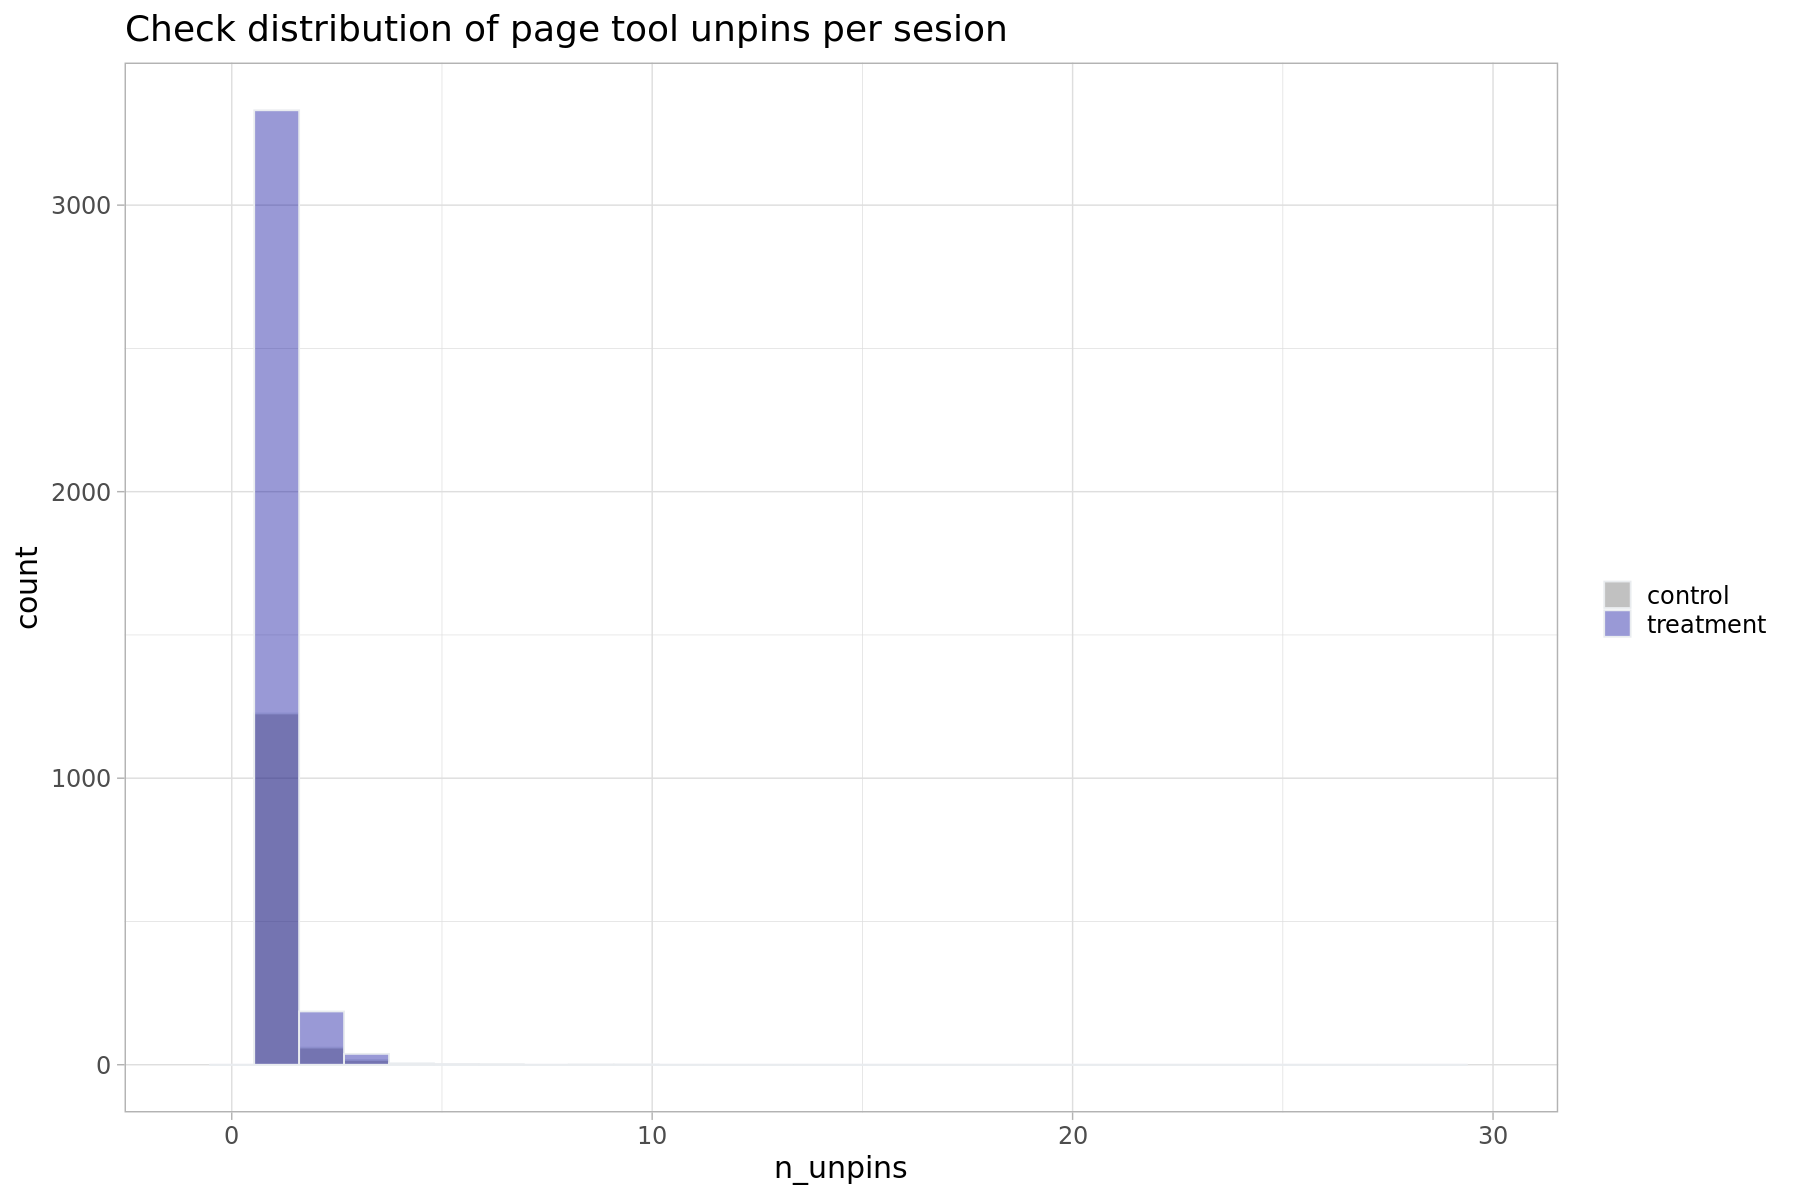

In [35]:
p1 <- df_pt_pv_per_session  %>%
  filter(n_unpins>0) %>%
  ggplot( aes(x=n_unpins, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
   scale_x_continuous(limits = c(-1,30)) +
    #scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of page tool unpins per sesion",
         fill="") +
    theme_light(base_size=18)
p1

Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


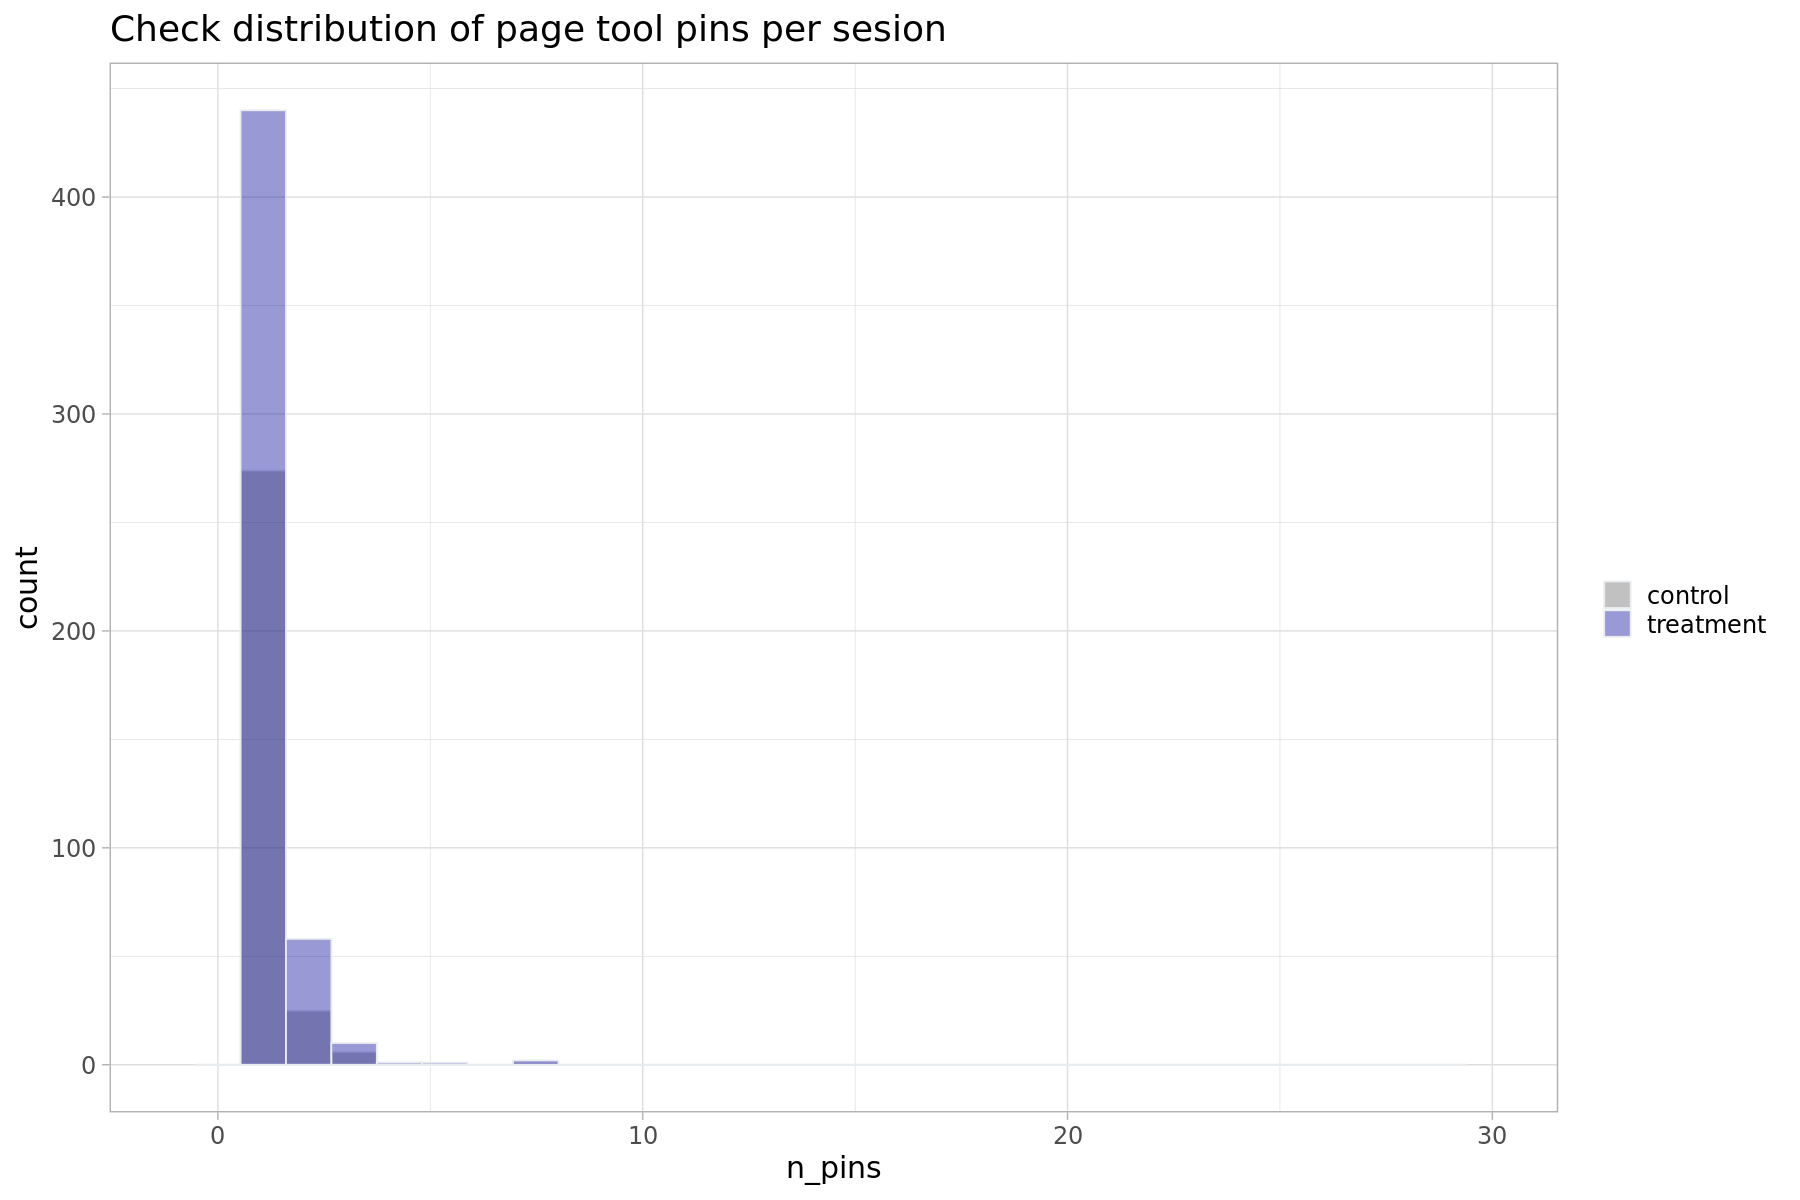

In [36]:
p1 <- df_pt_pv_per_session  %>%
   filter(n_pins>0) %>%
  ggplot( aes(x=n_pins, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
   scale_x_continuous(limits = c(-1,30)) +
    #scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of page tool pins per sesion",
         fill="") +
    theme_light(base_size=18)
p1

# By wiki

In [40]:
df_wiki <- df_pt_pv_per_session %>%
  group_by(wiki, test_group) %>%
  summarize(cnt_session_init=n_distinct(session_id), pvs_pageview=sum(n_pvs), pages_pageview=sum(n_pages), pins=sum(n_pins), unpins=sum(n_unpins),.groups='drop')

In [45]:
df_wiki %>% 
  group_by(test_group) %>%
  summarize( all_pins=sum(pins), all_unpins= sum(unpins),  all_pvs=sum(pvs_pageview), all_sessions=sum(cnt_session_init) , .groups='drop') %>%
   mutate( pins_per_session =round(all_pins/all_sessions,8),
          unpins_per_session =round( all_unpins/all_sessions,8)
          )

test_group,all_pins,all_unpins,all_pvs,all_sessions,pins_per_session,unpins_per_session
<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
control,353,1415,10056089,569972,0.00061933,0.00248258
treatment,610,3878,9868007,536839,0.00113628,0.00722377


In [46]:
0.00113628/0.00061933 -1

[1] 0.8346923

In [48]:
0.00722377/0.00248258 -1

[1] 1.909783

### Note

We observed a 83.47% increase in the page tool pins per session, a 190.98% increase in the page tool unpin per session from the users who were shown the new page separation across all participating Wikipedias and all editor experience levels.

In [ ]:
df_wiki <- df_wiki %>%
  mutate(
     pins_per_session= round(pins/cnt_session_init, 8),
     unpins_per_session= round(unpins/cnt_session_init, 8) 
      )

In [51]:
df_wiki

wiki,test_group,cnt_session_init,pvs_pageview,pages_pageview,pins,unpins,pins_per_session,unpins_per_session
<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
enwiki,control,451785,8032826,8031653,237,1064,0.00052459,0.00235510
enwiki,treatment,422227,7975065,7974056,416,2972,0.00098525,0.00703887
fawiki,control,9573,156055,155993,32,50,0.00334273,0.00522302
fawiki,treatment,8954,125034,125000,25,101,0.00279205,0.01127987
frwiki,control,55295,953480,953377,27,112,0.00048829,0.00202550
frwiki,treatment,52465,925160,925046,68,390,0.00129610,0.00743353
hewiki,control,9136,188825,188803,5,20,0.00054729,0.00218914
hewiki,treatment,9777,195126,195085,12,60,0.00122737,0.00613685
kowiki,control,4728,98851,98850,7,14,0.00148054,0.00296108


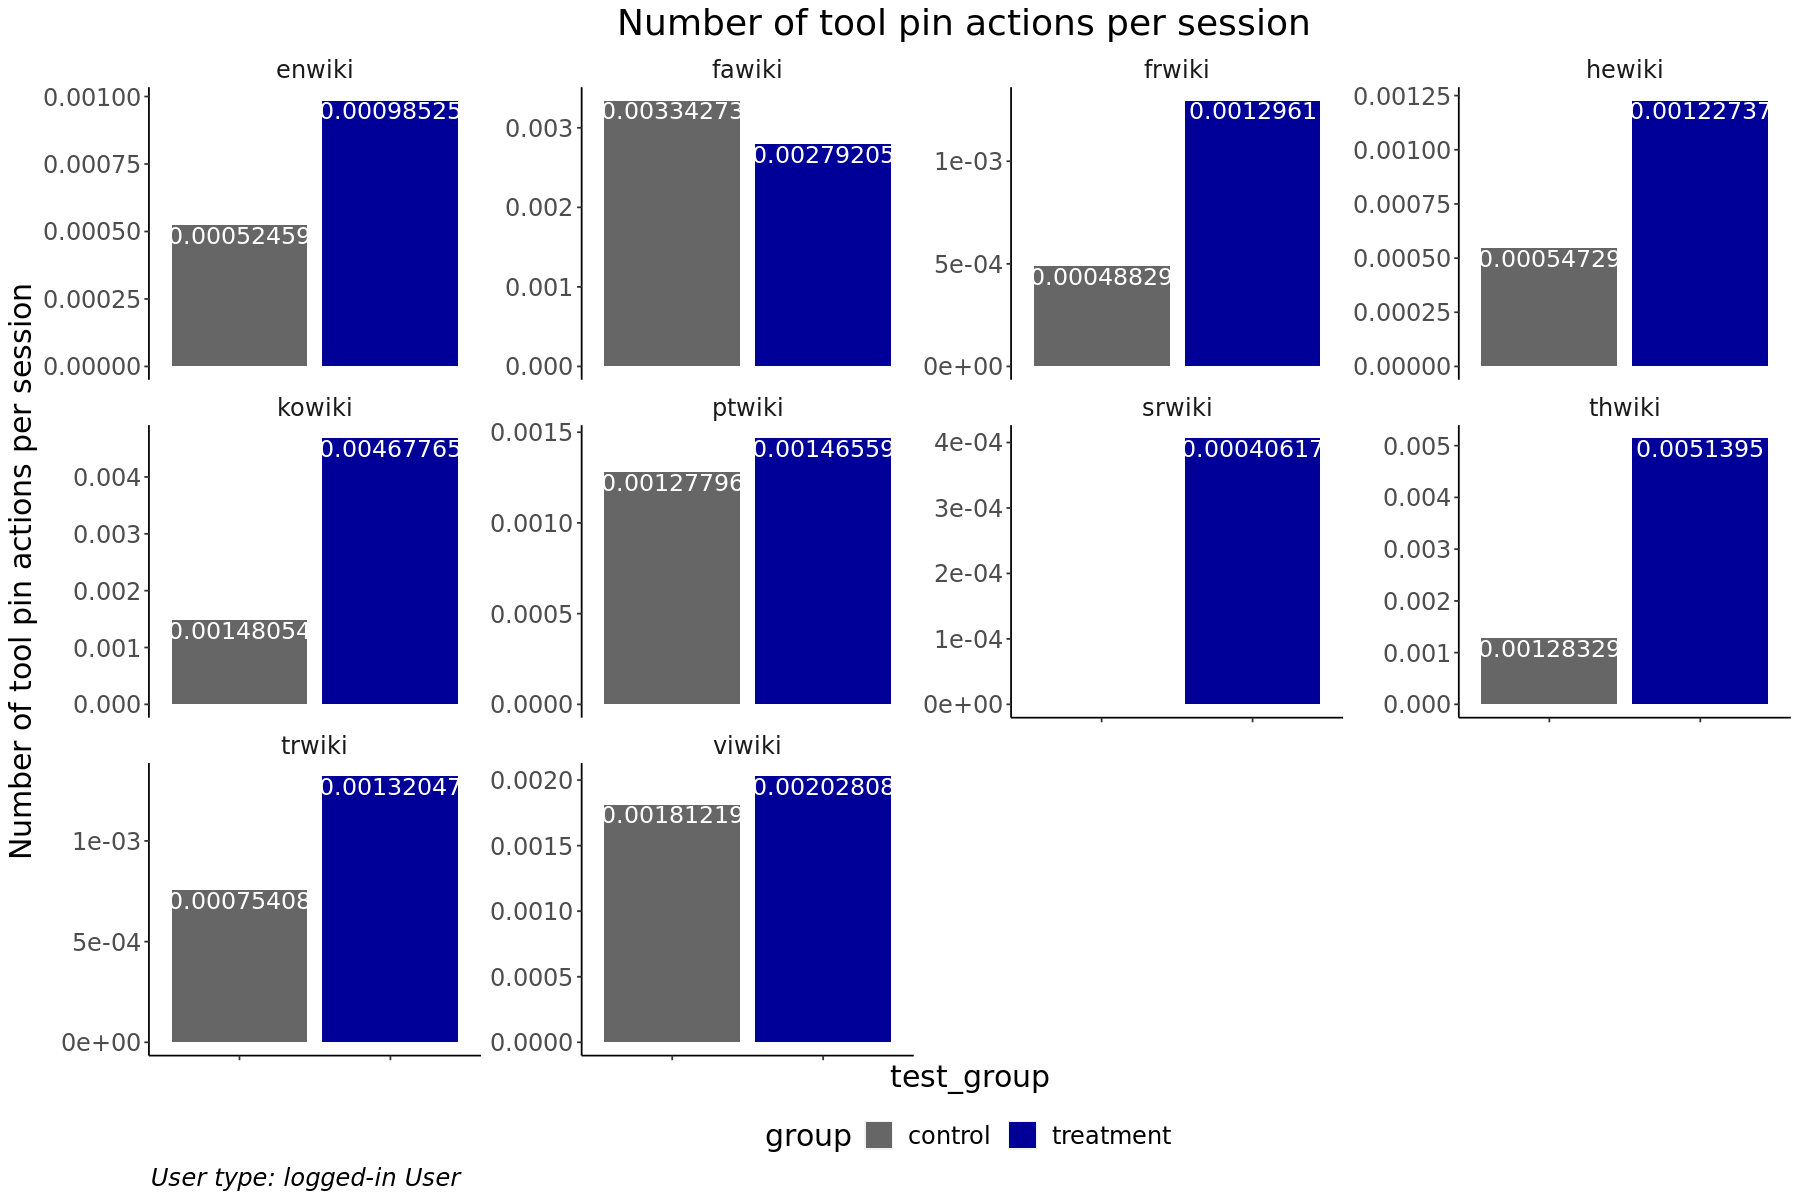

In [81]:
barchart_pins_per_session  <- df_wiki  %>%
        select(wiki, test_group, pins_per_session) %>%
        ggplot(aes(x = test_group, y= pins_per_session, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(pins_per_session)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.1, hjust = 0.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of tool pin actions per session" ,
             title = "Number of tool pin actions per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pins_per_session

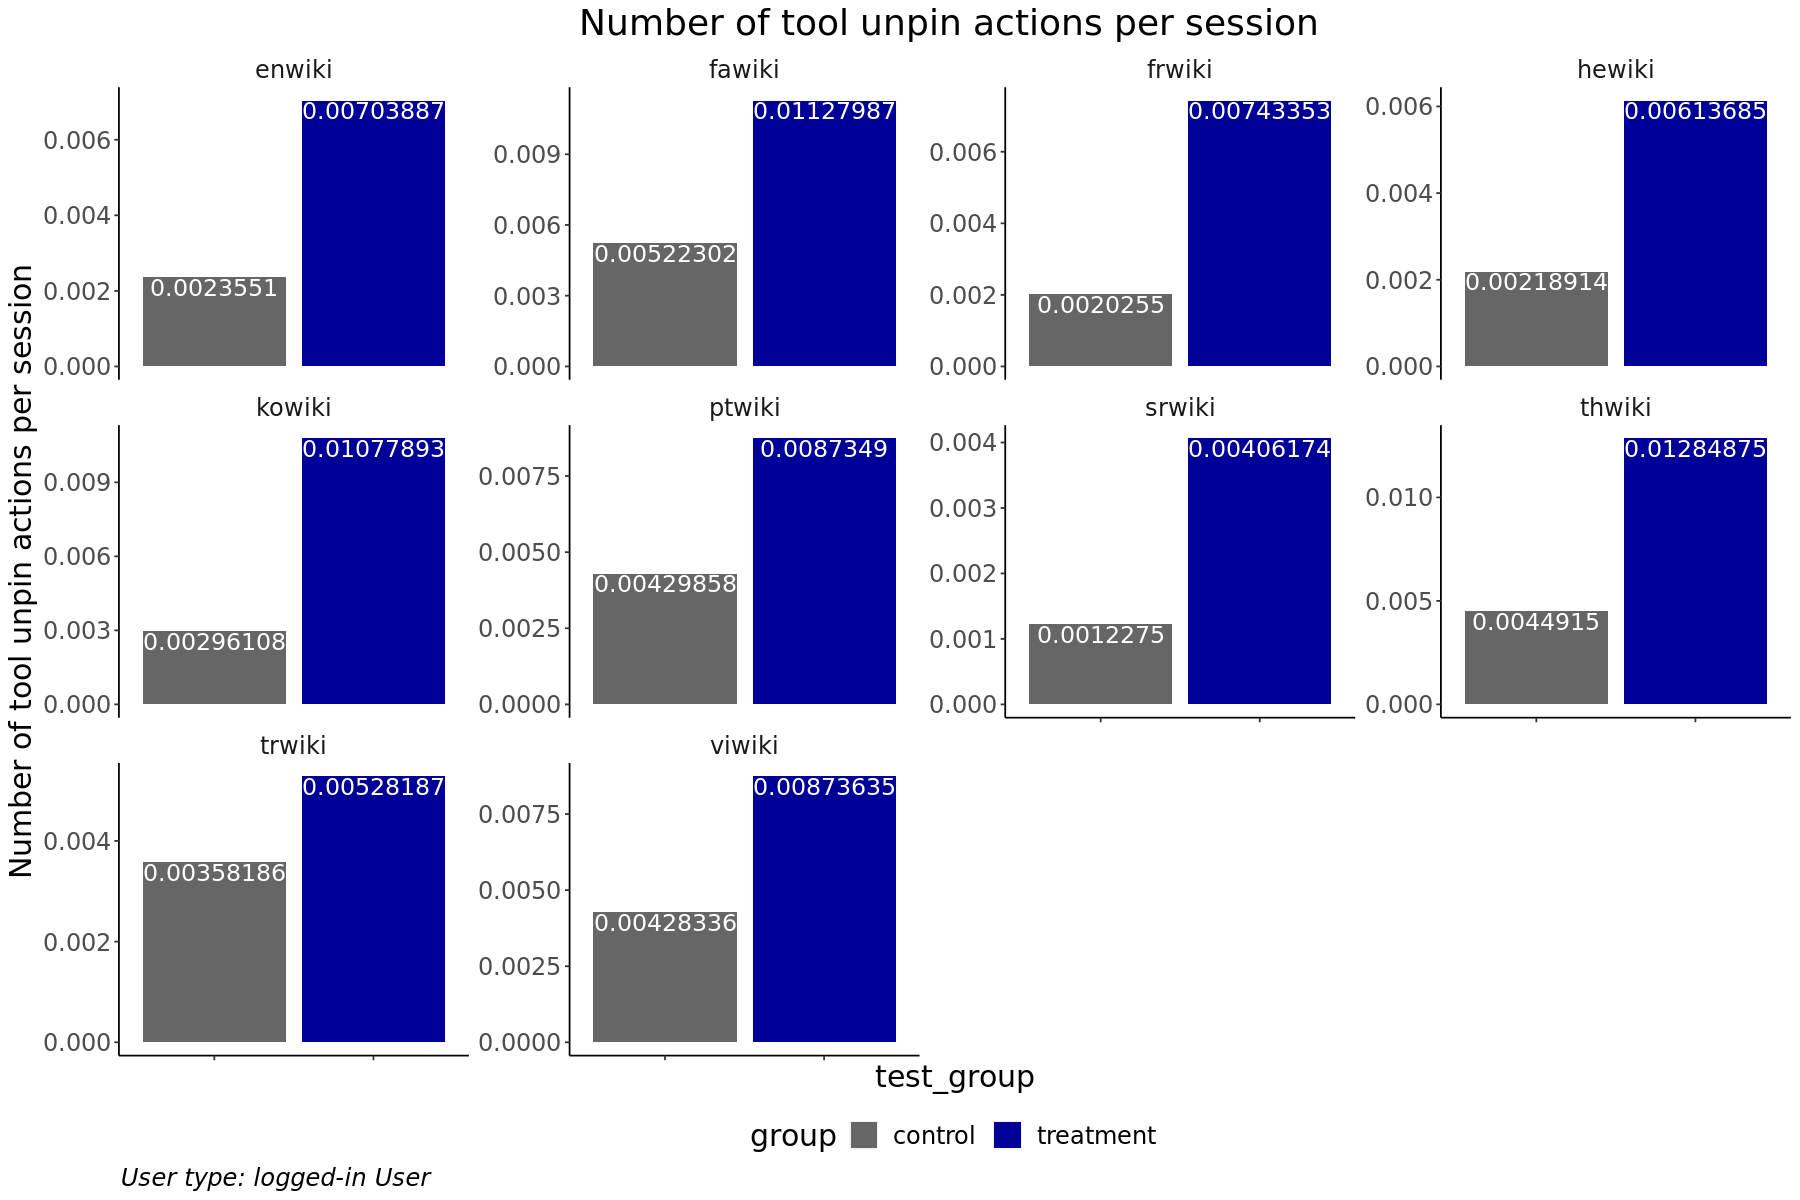

In [80]:
barchart_unpins_per_session  <- df_wiki  %>%
        select(wiki, test_group, unpins_per_session) %>%
        ggplot(aes(x = test_group, y= unpins_per_session, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(unpins_per_session)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.1, hjust = 0.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of tool unpin actions per session" ,
             title = "Number of tool unpin actions per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_unpins_per_session

### Note
The number of pins/unpin per session increased in treatment group across wikis.

# By edit count bucket

In [62]:
df_pt_pv_bucket  <- df_pagetool_pv %>% 
   group_by(session_id, wiki,test_group, editcountbucket) %>%
   summarize(n_pvs=sum(pvs), n_pages=n_distinct(page_token), n_pins=sum(pins, na.rm=T), n_unpins=sum(unpins,na.rm=T), .groups='drop')

In [65]:
df_pt_pv_bucket_per_session <- df_pt_pv_bucket  %>% 
  mutate(
          editcountbucket_n = 
            case_when(
                editcountbucket == '0 edits' ~ 0 ,
                editcountbucket == '1-4 edits' ~ 4,
                editcountbucket == '5-99 edits' ~ 99,
                editcountbucket == '100-999 edits'  ~ 999,
                editcountbucket == '1000+ edits' ~ 1000,
                TRUE ~ NA
            )
        ) %>%
   group_by(session_id, wiki, test_group ) %>%
   summarize(sum_pvs=sum(n_pvs), sum_pv_pages=sum(n_pages),
             sum_pins=sum(n_pins), 
             sum_unpins=sum(n_unpins), 
             editcountbucket_begin=min(editcountbucket_n),
             editcountbucket_end=max(editcountbucket_n),
             .groups='drop')

In [67]:
df_pt_pv_bucket_per_session <- df_pt_pv_bucket_per_session %>%
     mutate(
          editcountbucket_lab = factor(
            case_when(
                editcountbucket_begin == 0 ~ '0_edits'  ,
                editcountbucket_begin == 4 ~ '1_4_edits' ,
                editcountbucket_begin == 99 ~ '5_99_edits' ,
                editcountbucket_begin == 999 ~ '100_999_edits'  ,
                editcountbucket_begin == 1000 ~ '1000_more_edits',
                TRUE ~ 'others'
            ), levels = c('0_edits', '1_4_edits' ,'5_99_edits', '100_999_edits', '1000_more_edits', 'other')
          ) 
         )

In [76]:

df_pt_editbucket_overall <- df_pt_pv_bucket_per_session %>%
   group_by(test_group, editcountbucket_lab ) %>%
   summarize(total_pvs=sum(sum_pvs),total_pv_pages=sum(sum_pv_pages), n_sessions=n_distinct(session_id), 
             total_pins=sum(sum_pins),total_unpins=sum(sum_unpins),
             .groups='drop') %>%
   mutate( pin_per_session =round( total_pins/n_sessions,6) ,
           unpin_per_session =round(total_unpins/n_sessions,6)
            )

In [77]:
df_pt_editbucket_overall

test_group,editcountbucket_lab,total_pvs,total_pv_pages,n_sessions,total_pins,total_unpins,pin_per_session,unpin_per_session
<chr>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
control,0_edits,1675249,1674933,186627,137,668,0.000734,0.003579
control,1_4_edits,828957,828788,74938,39,150,0.000520,0.002002
control,5_99_edits,2253880,2253578,150087,77,325,0.000513,0.002165
control,100_999_edits,1686450,1686178,77818,38,140,0.000488,0.001799
control,1000_more_edits,3611553,3611155,80502,62,132,0.000770,0.001640
treatment,0_edits,1551263,1550968,153733,191,1510,0.001242,0.009822
treatment,1_4_edits,822927,822811,73213,56,445,0.000765,0.006078
treatment,5_99_edits,2207717,2207439,152687,115,895,0.000753,0.005862
treatment,100_999_edits,1750183,1749961,80104,78,540,0.000974,0.006741


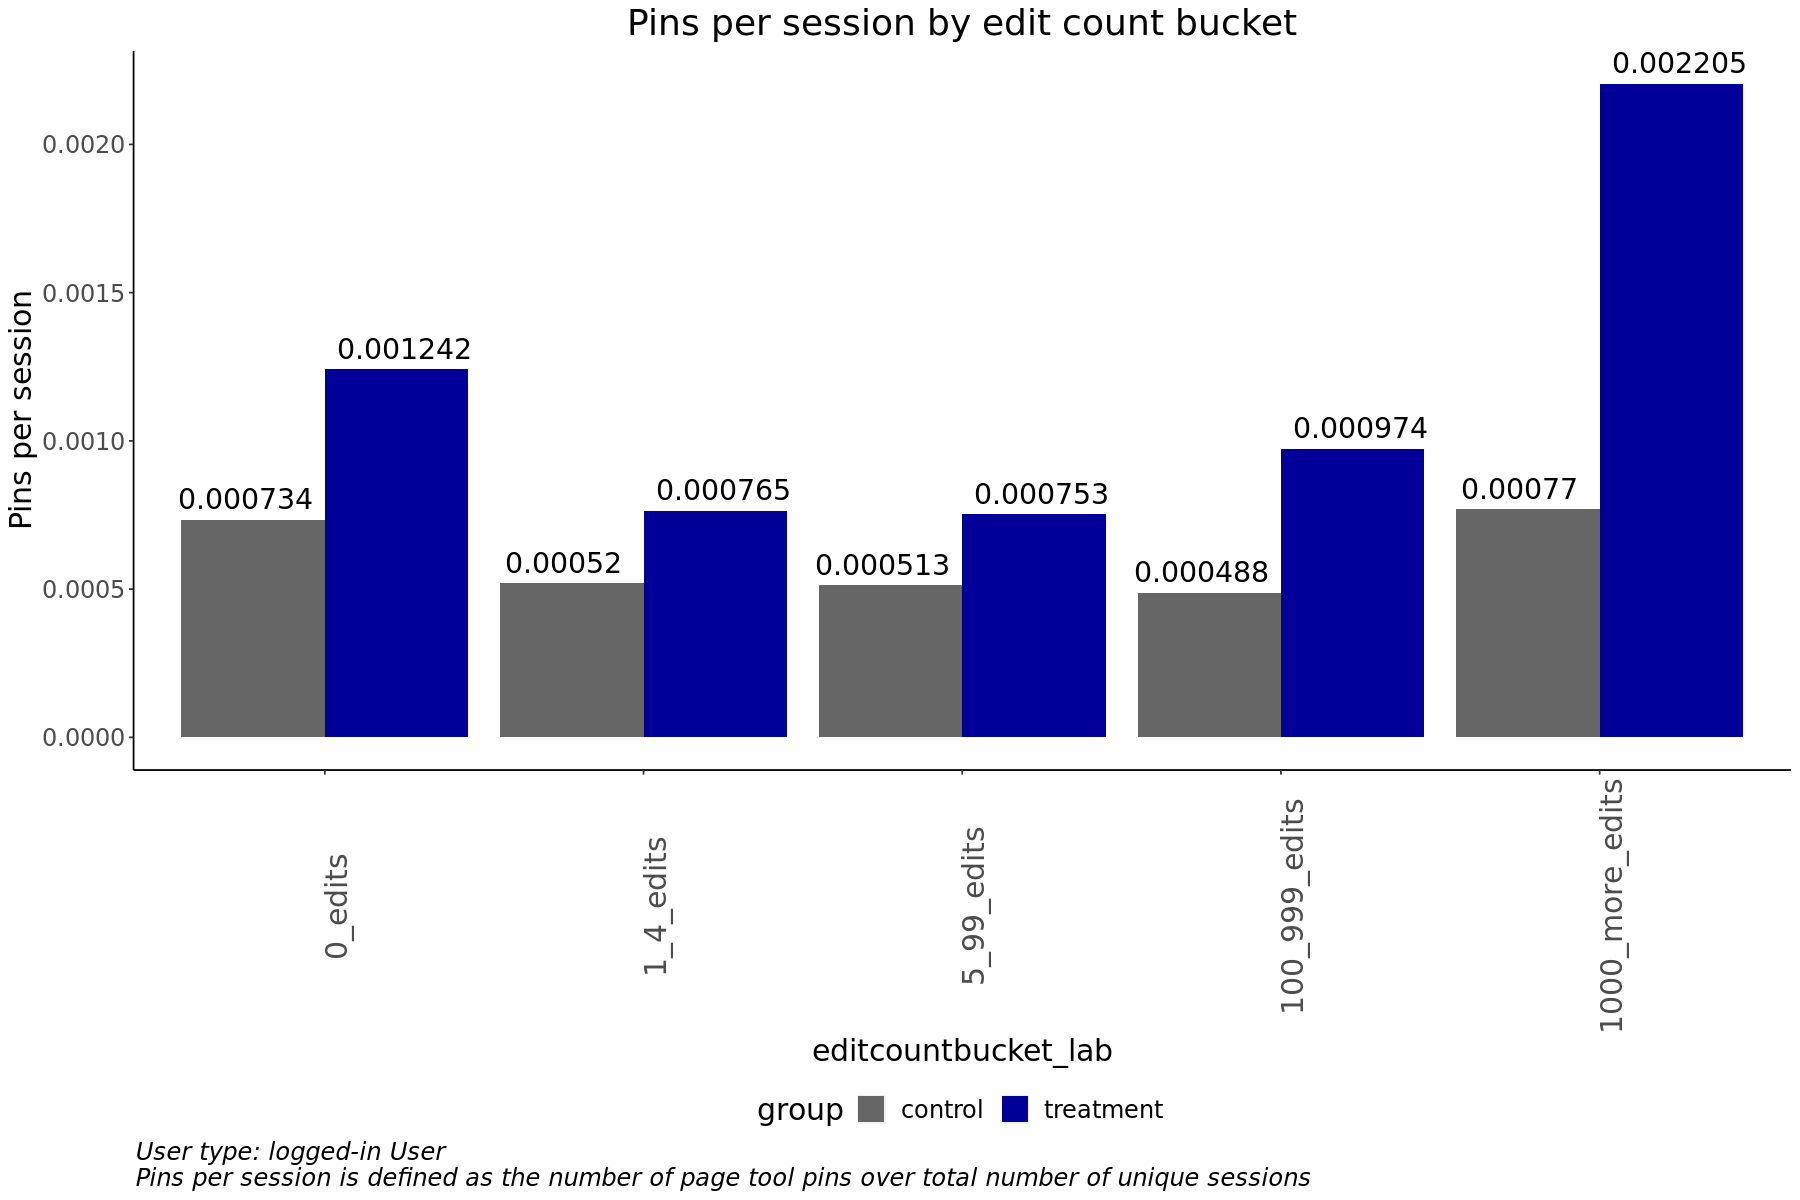

In [78]:
barchart_pin_editcountbucket_overall  <- df_pt_editbucket_overall  %>%
        ggplot(aes(x = editcountbucket_lab, y= pin_per_session, fill=test_group)) +
        geom_text(aes(label = paste(pin_per_session)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.5, hjust = 0.5, size = 6) +
        geom_bar(stat="identity", position = 'dodge') +
        labs (
              y = "Pins per session" ,
             title = "Pins per session by edit count bucket" ,
             caption = "User type: logged-in User
Pins per session is defined as the number of page tool pins over total number of unique sessions" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pin_editcountbucket_overall

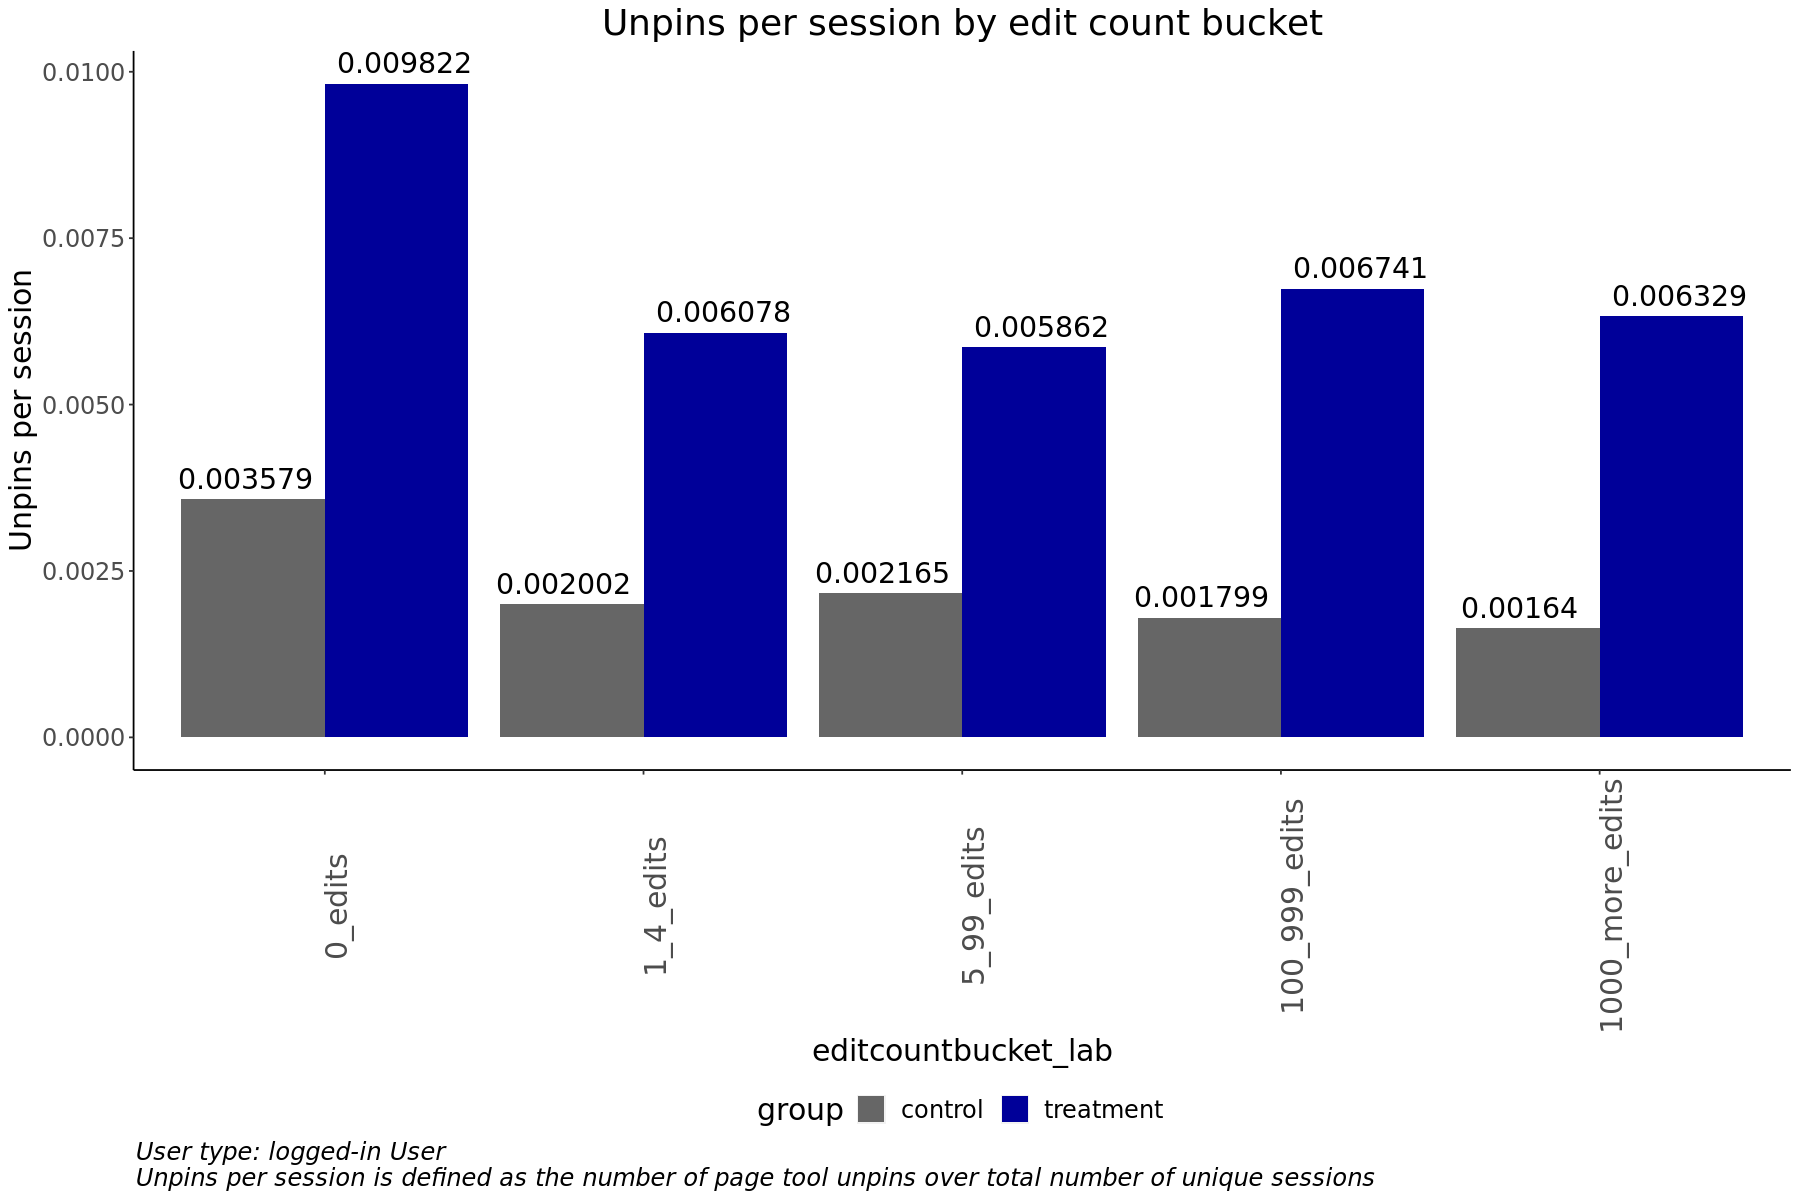

In [79]:
barchart_unpin_editcountbucket_overall  <- df_pt_editbucket_overall  %>%
        ggplot(aes(x = editcountbucket_lab, y= unpin_per_session, fill=test_group)) +
        geom_text(aes(label = paste(unpin_per_session)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.5, hjust = 0.5, size = 6) +
        geom_bar(stat="identity", position = 'dodge') +
        labs (
              y = "Unpins per session" ,
             title = "Unpins per session by edit count bucket" ,
             caption = "User type: logged-in User
Unpins per session is defined as the number of page tool unpins over total number of unique sessions" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_unpin_editcountbucket_overall

### Note

When broken down by the editor's experience levels, the increase of pins and unpins in treatment group remains consistent across all edit count buckets.